File used for testing the functions in the repository

<h2> Deep Learning <h2>

In [1]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
import torch.nn.init as init
import torch.nn.functional as F
import matplotlib.pyplot as plt
from source.Data_generation import IRF, equidistant_interpolation, c_tissue, simulated_tac
from source.Plots import *
#from source.models.FC_nn_single_bounded import FC_single_bounded
from source.Train import training_single_model, training_parallel_models

In [28]:
def IRF_torch(gt_parameters_tensor, equidistant_rtim_tensor):
    """
    Calculates the impulse response function (IRF) for the given parameters and equidistant timepoints using PyTorch.

    Parameters:
    gt_parameters_tensor (torch.Tensor): Tensor of parameters.
    equidistant_rtim_tensor (torch.Tensor): Tensor of equidistant timepoints.

    Returns:
    torch.Tensor: The IRF values.
    """
    # Given that gt_parameters_tensor shape is [batch_size, 4]
    k1, k2, k3 = gt_parameters_tensor[:, 0], gt_parameters_tensor[:, 1], gt_parameters_tensor[:, 2]
    k4 = torch.zeros_like(k1)  # Ensuring k4 is the same shape and device as k1

    # Calculate alphas for the entire batch
    sqrt_term = torch.sqrt(torch.clamp((k2 + k3 + k4)**2 - 4*k2*k4, min=0))
    alpha1 = (k2 + k3 + k4) - sqrt_term / 2.0
    alpha2 = (k2 + k3 + k4) + sqrt_term / 2.0

    # Calculate IRF for each time point and each batch
    epsilon = 1e-8
    equidistant_rtim_tensor = equidistant_rtim_tensor.unsqueeze(0)  # Adding a batch dimension for broadcasting
    value = ((k3 + k4 - alpha1).unsqueeze(1) * torch.exp(-alpha1.unsqueeze(1) * equidistant_rtim_tensor) + 
             (alpha2 - k3 - k4).unsqueeze(1) * torch.exp(-alpha2.unsqueeze(1) * equidistant_rtim_tensor)) / (alpha2 - alpha1 + epsilon).unsqueeze(1)
    
    IRF = value * k1.unsqueeze(1)  # Ensuring k1 is correctly broadcasted over the time dimension

    return IRF


def c_tissue_torch(IRF_tensor, pchip_tensor, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.
    This version ensures that inputs and kernels are properly shaped for PyTorch's conv1d.

    Parameters:
    IRF_tensor (torch.Tensor): The IRF values as a tensor.
    pchip_tensor (torch.Tensor): Plasma concentration values as a tensor, interpolated using PCHIP or equivalent.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values as a tensor.
    """
    # Ensure tensors have the correct shape (Batch, Channel, Length)
    if IRF_tensor.dim() == 1:
        IRF_tensor = IRF_tensor.unsqueeze(0).unsqueeze(0)
    elif IRF_tensor.dim() == 2:
        IRF_tensor = IRF_tensor.unsqueeze(1)

    if pchip_tensor.dim() == 1:
        pchip_tensor = pchip_tensor.unsqueeze(0).unsqueeze(0)
    elif pchip_tensor.dim() == 2:
        pchip_tensor = pchip_tensor.unsqueeze(1)

    # Perform 1D convolution. Flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    padding_size = (IRF_tensor.size(-1) - 1)
    simulated_c_tissue_values = F.conv1d(pchip_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)[:,:,:pchip_tensor.size(-1)]

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary batch and channel dimensions before returning
    return normalized_result_tensor.squeeze()


def simulated_tac_torch(c_tissue, gt_parameters, bl_tensor):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values using PyTorch.

    Parameters:
    c_tissue (torch.Tensor): The C_Tissue values with shape [batch_size, num_points].
    gt_parameters (torch.Tensor): The ground truth parameters with shape [batch_size, num_params].
    bl_tensor (torch.Tensor): Blood concentration values with shape [num_points].

    Returns:
    torch.Tensor: The simulated TAC values with shape [batch_size, num_points].
    """
    # Extracting the 'vb' parameter from the ground truth parameters, assuming it is the fourth parameter
    # The shape of vb is [batch_size, 1] after unsqueezing
    vb = gt_parameters[:, 3].unsqueeze(1)

    # Broadcasting 'vb' and 'bl_tensor' across the batch size and num_points, respectively, for efficient computation
    simulated_tac_values = c_tissue * (1 - vb) + vb * bl_tensor

    return simulated_tac_values


def TAC_loss(predicted_param, inputs, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in rtim_list]
    
    # Calculate the impulse response functions:
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    # Calculate the C-Tissue values
    dt = new_rtim[1] - new_rtim[0]
    pred_c_tissue = c_tissue_torch(pred_irf, pchip_pl_tensor, dt)

    # # Prints to understand the shapes of the tensors
    # print("pred_c_tissue:", pred_c_tissue.shape)
    # print("pred para:", predicted_param.shape)
    # print("inputs:", inputs.shape)

    # Calculate the simulated TAC values
    pred_tac = simulated_tac_torch(pred_c_tissue, predicted_param, pchip_bl_tensor)

    # # Plot one of the tac values for verification
    # plt.plot(pred_tac[0].detach().numpy())
    # plt.show()

   # Calculate the loss for each time window 
    tac_loss_list = []

    for i in range(len(rtim_list)):
        if i == len(rtim_list) - 1:
            # Last interval
            interval_tac = pred_tac[:, closest_indices[i]:]
            interval_inputs = inputs[:, closest_indices[i]:]
        else:
            interval_tac = pred_tac[:, closest_indices[i]:closest_indices[i+1]]
            interval_inputs = inputs[:, closest_indices[i]:closest_indices[i+1]]

        # Calculate the loss for the current interval and append to the list
        interval_loss = nn.MSELoss()(interval_tac, interval_inputs)
        tac_loss_list.append(interval_loss)

    # Convert the list of losses into a tensor
    tac_loss_tensor = torch.stack(tac_loss_list)

    # Calculate the mean loss across all intervals
    mean_tac_loss = torch.mean(tac_loss_tensor)

    return mean_tac_loss

In [38]:
class FC_single_bounded(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_single_bounded, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match the data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(64, 4)  # Output layer

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid to all outputs
        
        # Apply different transformations for each output
        a = torch.tensor([0.28, 0.15, 0.7, 0.35])  # Scaling factors
        b = torch.tensor([0.13, 0.014, 0.025, 0.05])  # Shifts
        x = 1.75 * a * x + b - 0.25 * a # Apply scaling and shifting with a margin

        return x

In [11]:
class FC_single_bounded(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_single_bounded, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match the data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(64, 4)  # Output layer

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid to all outputs
        
        # Apply different transformations for each output
        a = torch.tensor([7/15, 0.25, 7/6, 7/12])  # Scaling factors
        b = torch.tensor([11/300, -9/250, -5/24, -1/15])  # Shifts
        x = a * x + b # Apply scaling and shifting with a margin

        return x

In [31]:
#loss = nn.MSELoss()
#loss = nn.L1Loss()
loss = TAC_loss

config = { 
    'data': np.load("data/Generated_Data/simulation_simple_0.05.npz"),
    'model_class': FC_single_bounded,
    'loss_function': loss,
    'batch_size': 1024,
    'lr': 0.001,
    'patience': 15,
    'epochs': 250,
    'progress': True,
    'TAC_loss': True,
    'n_models': 3
}

In [32]:
# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

results_list = []
n_models = config['n_models']
for i in range(n_models):
    print(f"Training model {i + 1}")
    model, results = training_single_model(config)
    # Append the results
    results_list.append(results)    

Training model 1
Epoch 1, Validation Loss: 257.42023176999436
Epoch 2, Validation Loss: 275.2276611328125
Epoch 3, Validation Loss: 267.36283685743194
Epoch 4, Validation Loss: 265.40173198267354
Epoch 5, Validation Loss: 260.9175059525008
Epoch 6, Validation Loss: 256.1527568384544
Epoch 7, Validation Loss: 252.38953643484214
Epoch 8, Validation Loss: 239.91982261421754
Epoch 9, Validation Loss: 238.54754528556902
Epoch 10, Validation Loss: 219.5933842609838
Epoch 11, Validation Loss: 236.38841971171271
Epoch 12, Validation Loss: 265.3299511781673
Epoch 13, Validation Loss: 262.33367935652586
Epoch 14, Validation Loss: 257.6007081651196
Epoch 15, Validation Loss: 251.73547552049774
Epoch 16, Validation Loss: 253.05375938808794
Epoch 17, Validation Loss: 243.74685307138975
Epoch 18, Validation Loss: 233.04701468870812
Epoch 19, Validation Loss: 214.97412014990738
Epoch 20, Validation Loss: 202.54272523860342
Epoch 21, Validation Loss: 231.06694833027947
Epoch 22, Validation Loss: 267.8

Average of mean percentage differences: [-48.38087  132.784    -92.458565  78.55436  306.87265 ]
Average of std percentage differences: [ 43.36745   73.73937  368.6597    17.452114 409.68857 ]
Average of mean differences: [-0.09990525  0.10158464  0.11432203  0.18447167  0.12684427]
Average of std differences: [0.0710456  0.05171494 0.26412538 0.10010922 0.08051158]


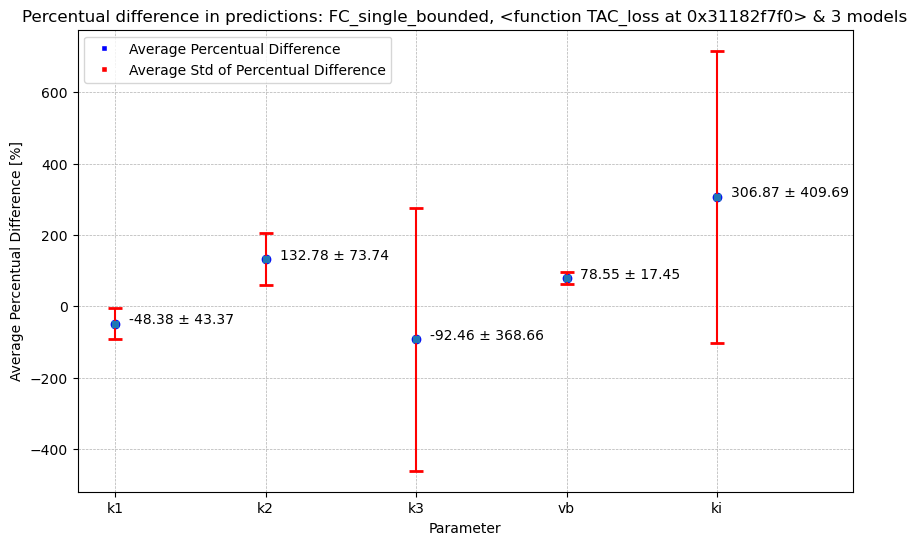

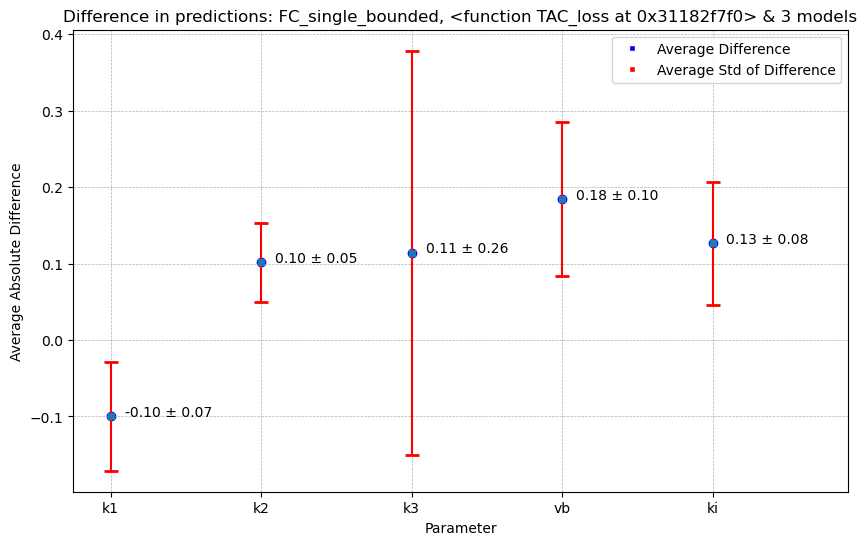

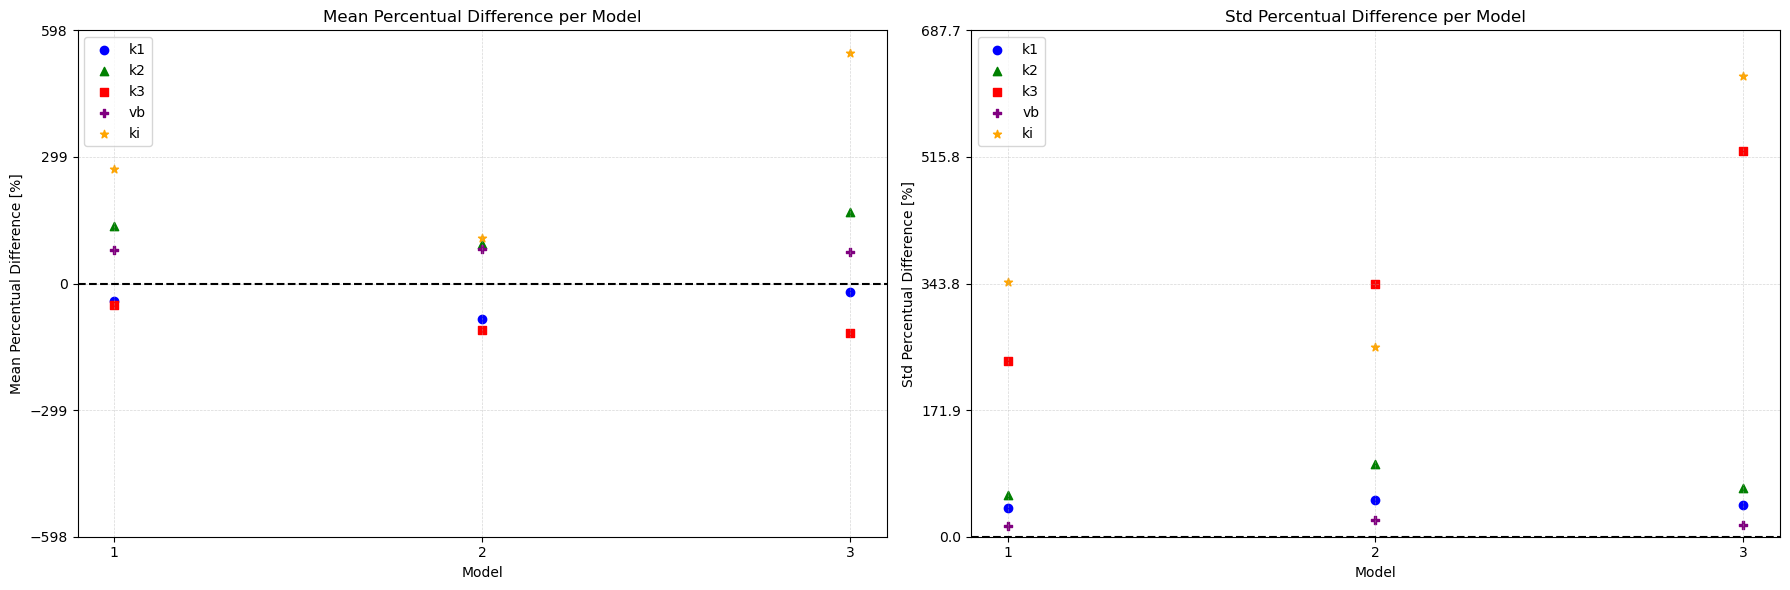

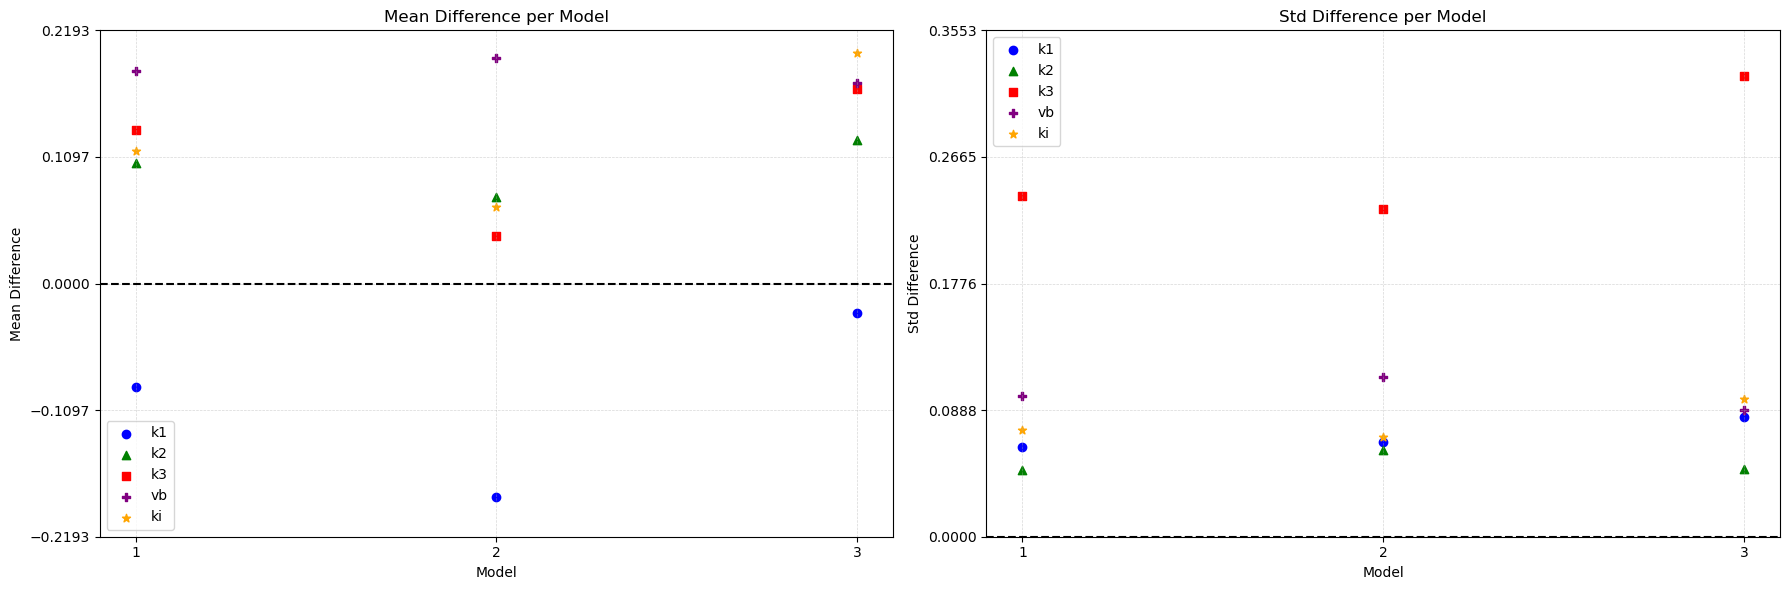

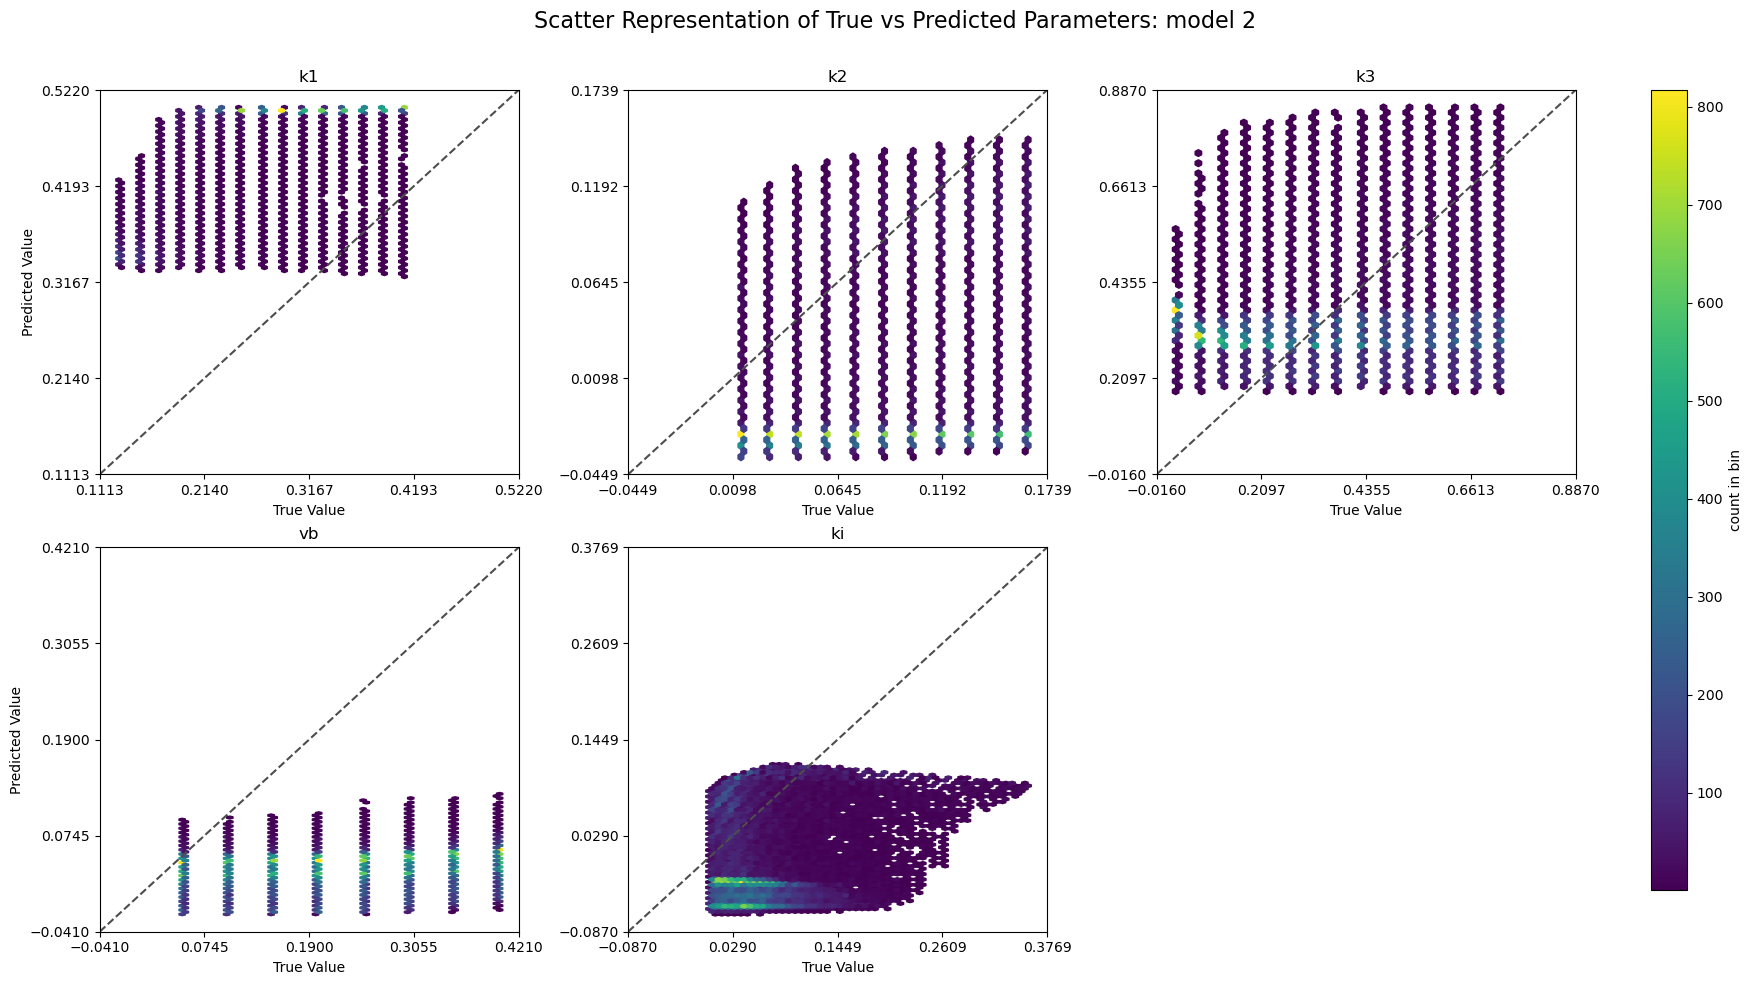

In [33]:
# Plot the mean and variance of the results
plot_mean_variance(results_list, config)
distribution_mean_std(results_list)
scatter_representation(results_list)

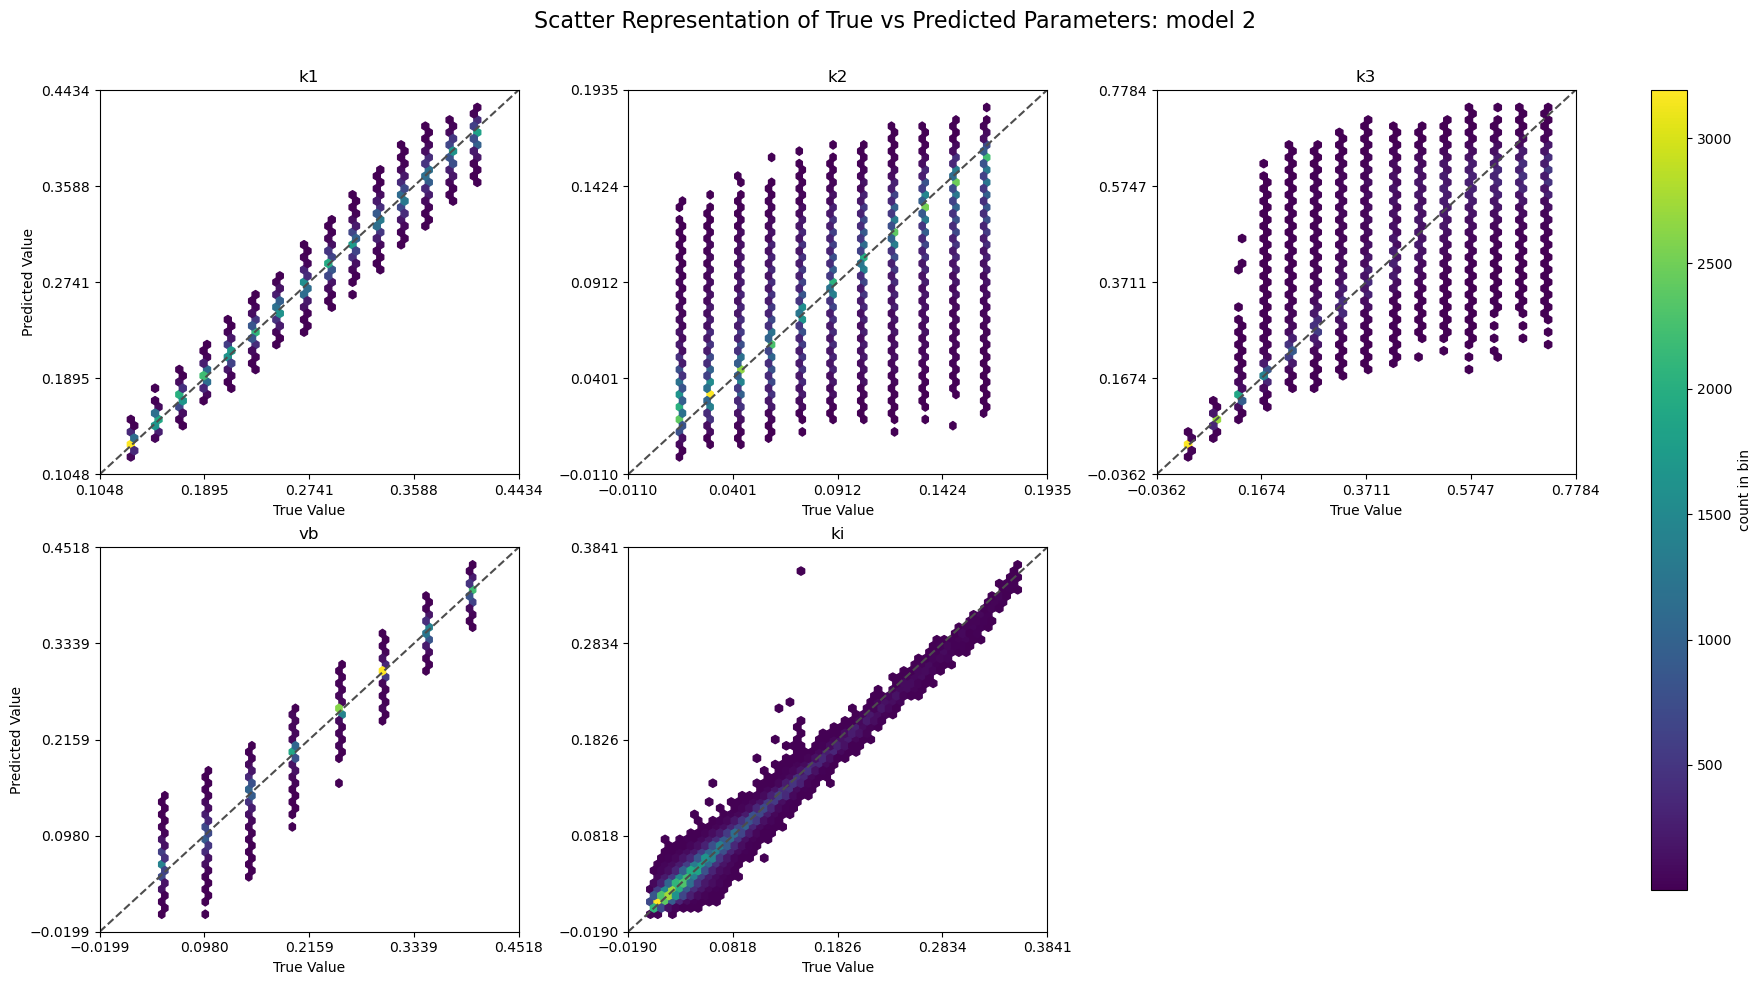

In [19]:
scatter_representation(results_list)

<h3>Parallel network<h3>

In [20]:
class FC_parallel_bounded(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_parallel_bounded, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match your data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(64, 1)  # Output layer

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))

        x = 0.711 * x + 0.014  # Scale the output to [0.014, 0.725]

        return x

In [22]:
class FC_parallel_bounded(nn.Module):
    def __init__(self, in_features, dropout_rate=0.1):
        super(FC_parallel_bounded, self).__init__()
        self.fc1 = nn.Linear(in_features, 256)  # Adjust in_features to match the data
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first activation
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second activation
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(64, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = self.dropout4(torch.relu(self.bn4(self.fc4(x))))
        x = torch.sigmoid(self.fc5(x))  # Apply sigmoid to all outputs
        
        x = 7/6 * x - 1/15  # Scale the output

        return x

In [29]:
# Set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Load the data and define the loss function
#loss = nn.MSELoss()
#loss = nn.L1Loss()
loss = TAC_loss

config = { 
    'data': np.load("data/Generated_Data/simulation_simple_0.05.npz"),
    'model_class': FC_parallel_bounded,
    'loss_function': loss,
    'batch_size': 1024,
    'lr': 0.001,
    'patience': 15,
    'epochs': 250,
    'progress': True,
    'TAC_loss': True,
    'n_models': 3
}

In [30]:
# Initialize lists to collect the arrays
results_list = []
n_models = config['n_models']
for i in range(n_models):
    print(f"Training model {i + 1}")
    model, results = training_parallel_models(config)
    # Append the results
    results_list.append(results)

Training model 1
Epoch 1, Validation Loss: 258.0584636570252
Epoch 2, Validation Loss: 298.06349512473827
Epoch 3, Validation Loss: 188.87692056242952


KeyboardInterrupt: 

Average of mean percentage differences: [ -0.38280106 -17.01754     -4.9810624   -6.4211135   -9.0869255 ]
Average of std percentage differences: [ 5.918079 72.54978  29.364336 18.174438 52.192455]
Average of mean differences: [-0.00058176  0.00035339 -0.00586524 -0.00453583 -0.00081504]
Average of std differences: [0.01284966 0.02891583 0.08645236 0.01403191 0.02135838]


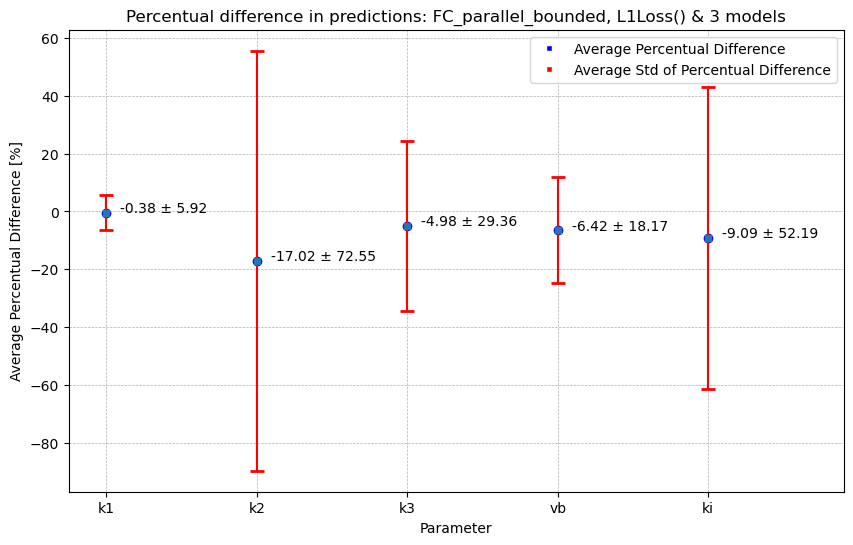

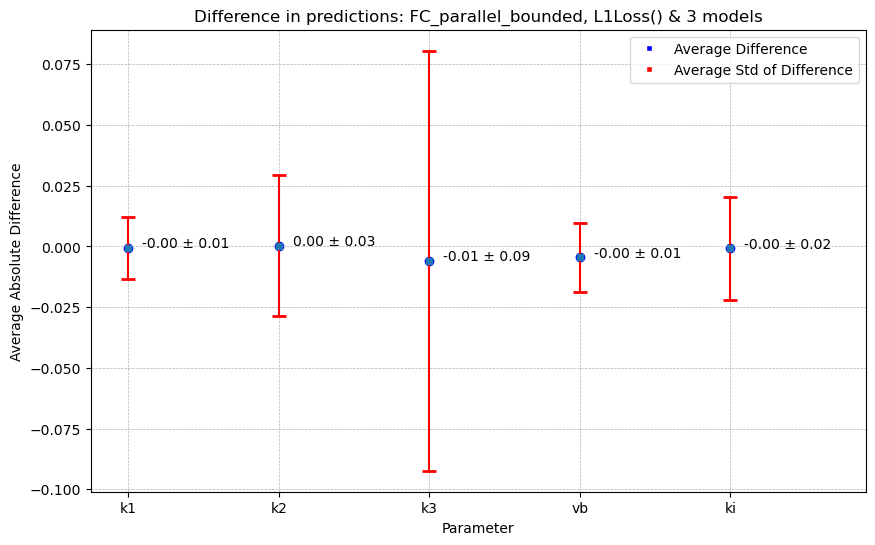

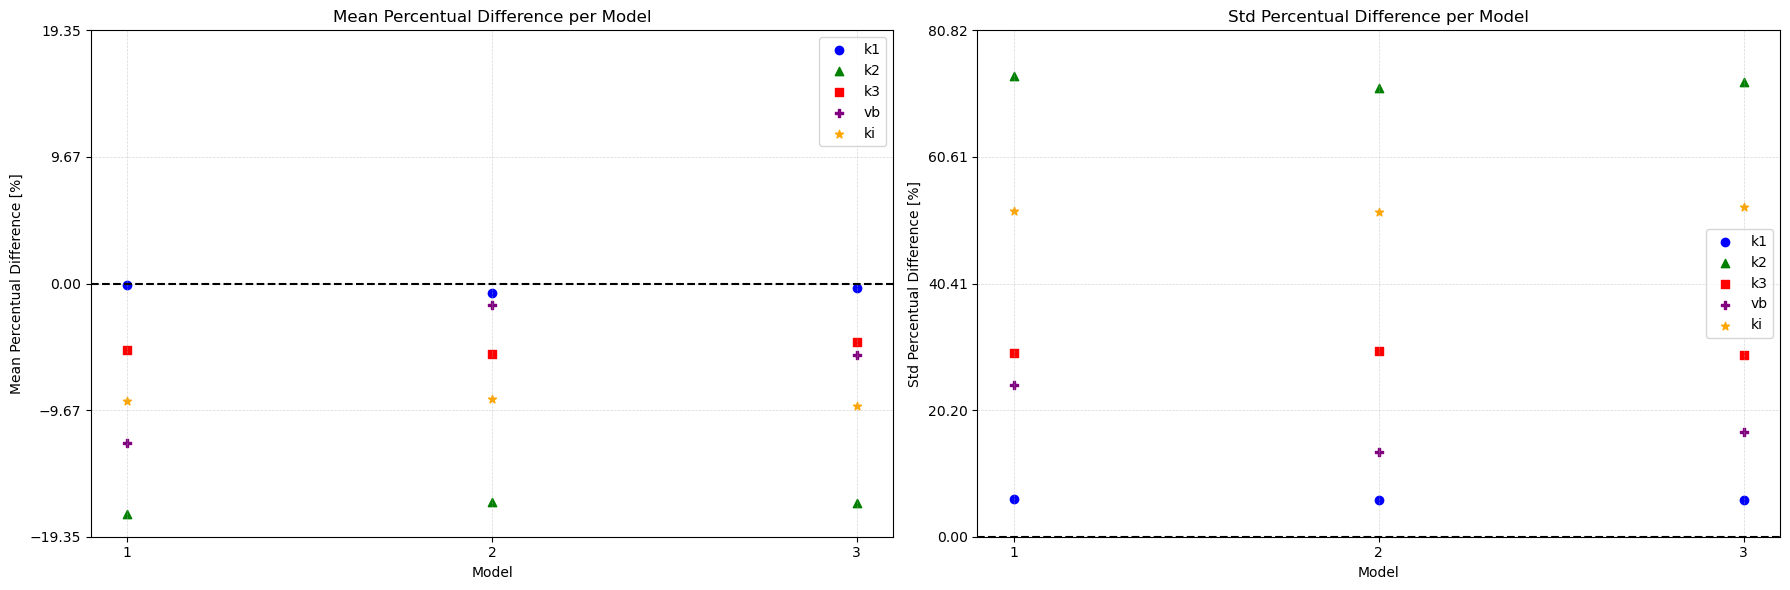

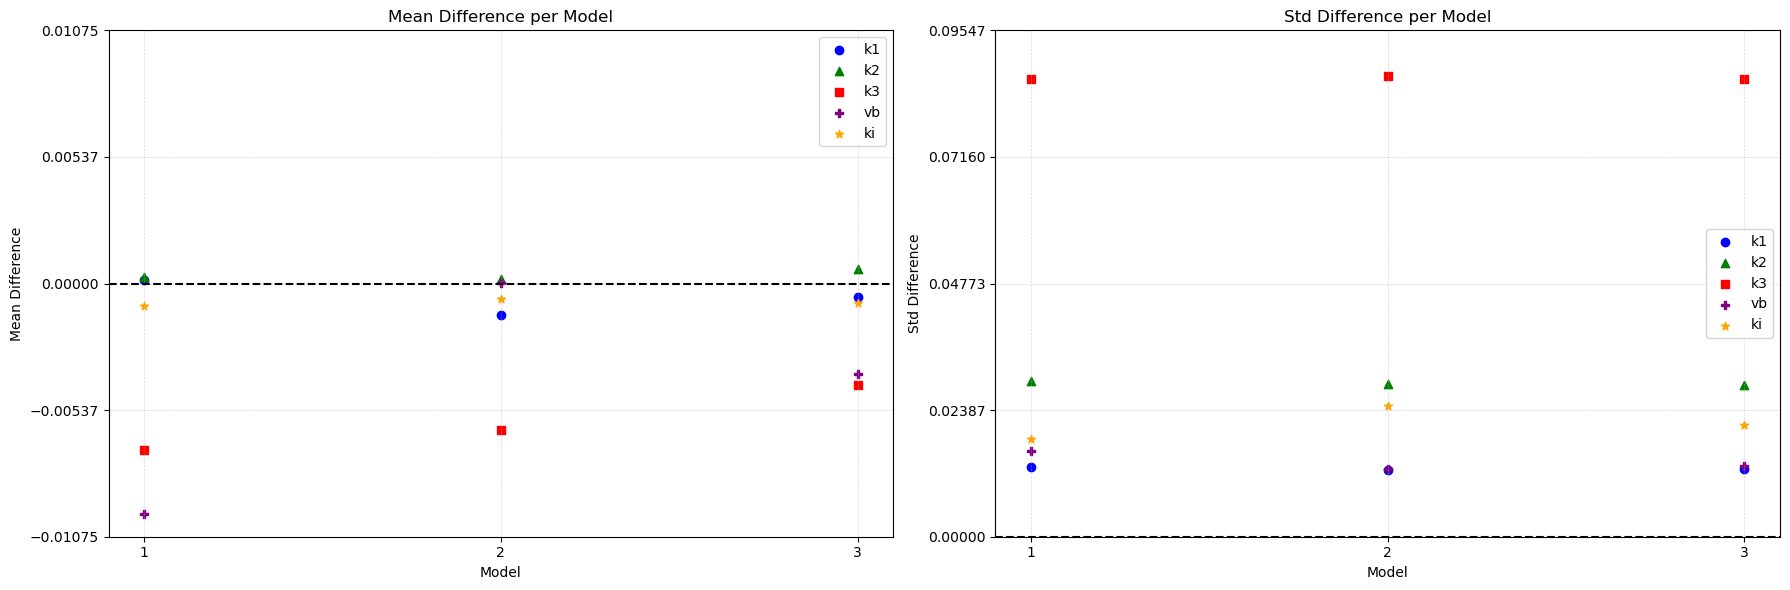

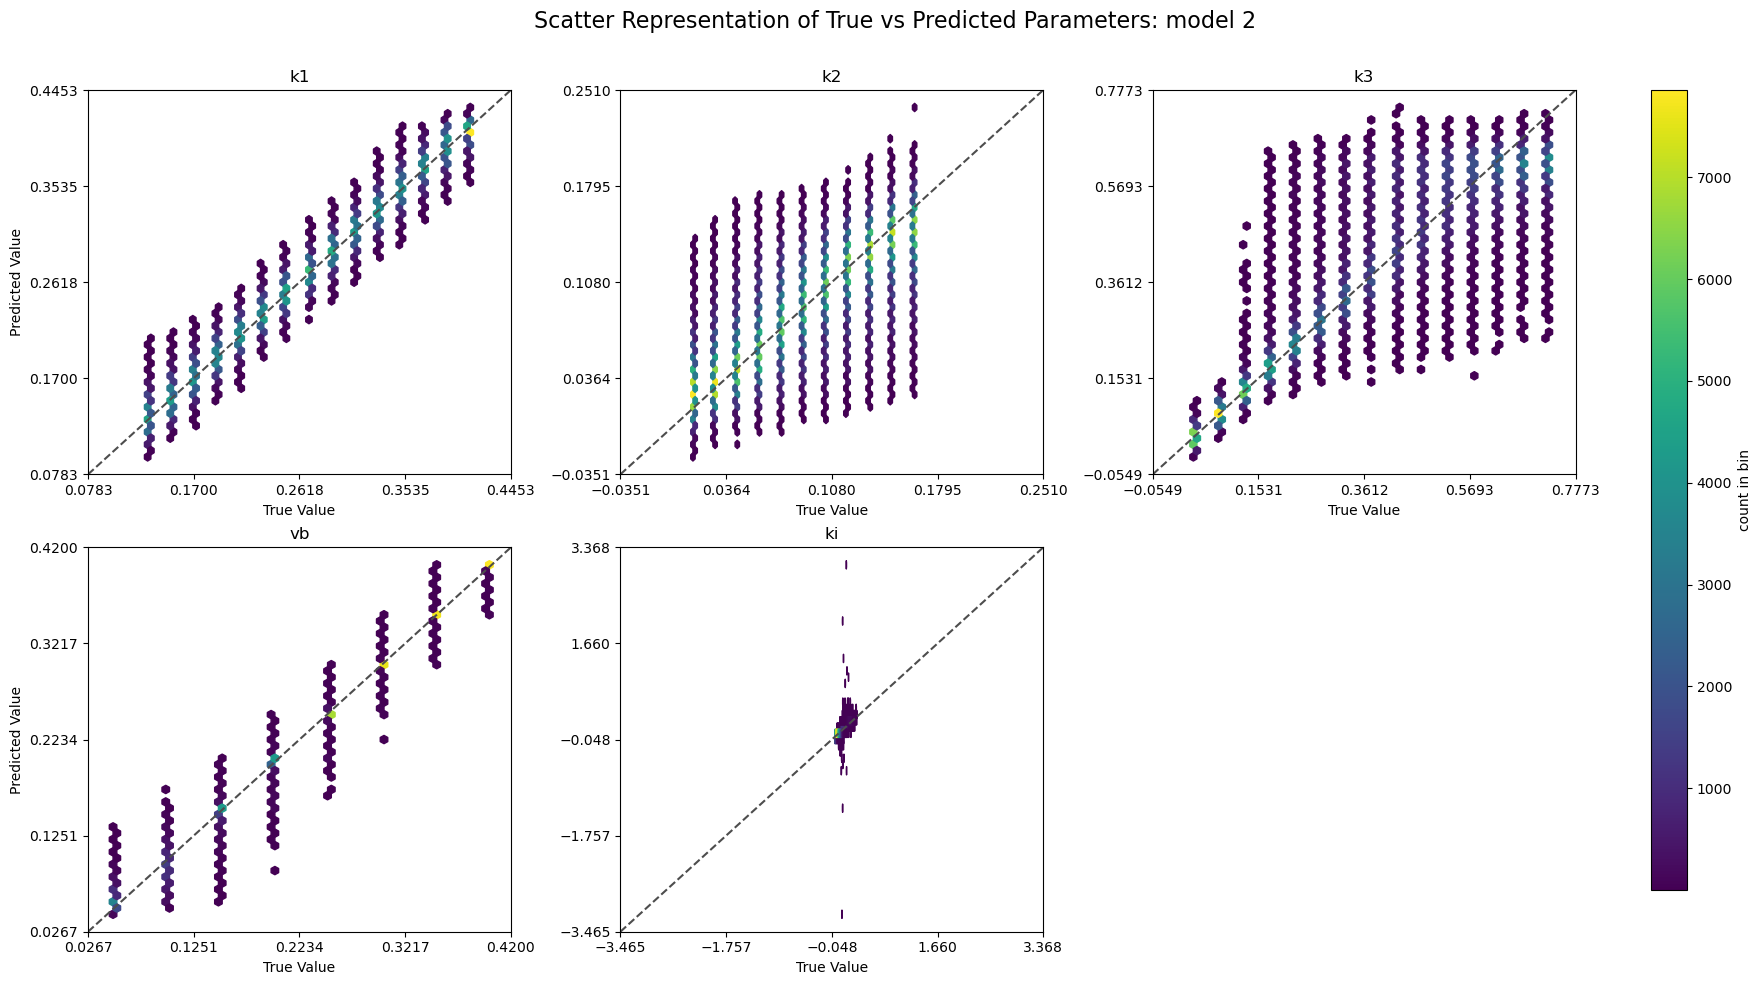

In [26]:

# Plot the mean and variance of the results
plot_mean_variance(results_list, config)
distribution_mean_std(results_list)
scatter_representation(results_list)